In [2]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pickle
#import seaborn as sns

In [3]:
def load_data(path):
    df = pd.read_csv(path, sep=';')
    df = df.rename(columns={
        'User DL Average Throughput_LTE(kB/s)' : 'dl_avg',
        'User UL Average Throughput_LTE(kB/s)' : 'ul_avg',
        'Cell DL Peak Throughput_LTE(MB/s)' : 'dl_peak',
        'Cell UL Peak Throughput_LTE(MB/s)' : 'ul_peak'
    })
    df = df[df.columns[:-1]]
    df = df.dropna()
    df['eNodeB Name'] = df['eNodeB Name'].apply(lambda x: str(x).lower())
    df['Time']=pd.to_datetime(df['Time'])
    
    filtered = df[df['eNodeB Name'].map(df['eNodeB Name'].value_counts()) == 720]
    filtered = filtered.rename(columns={'Time':'ds'})
    bts_name = filtered['eNodeB Name'].unique()
    
    return filtered, bts_name

# get data
def get_data(bts_data, bts_name, column):
    bts_data = bts_data[bts_data['eNodeB Name']==bts_name]
    bts_data_col = bts_data.rename(columns={f'{column}':'y'})
    bts_data_col = bts_data_col[['ds', 'y']]
    bts_data_col = bts_data_col.set_index('ds')
    bts_data_col.index = pd.DatetimeIndex(bts_data_col.index).to_period('H')
    return bts_data_col

In [4]:
path = 'D:/Kuliah/SEM7/TA1/prophet/data/data throughput only.csv'
data, bts_names = load_data(path)
cols = ['dl_avg', 'ul_avg', 'dl_peak', 'ul_peak']

In [5]:
bts_data = get_data(data, bts_names[0], cols[0])
bts_data

,y
ds,
2017-04-03 00:00,6.1402
2017-04-03 01:00,8.5089
2017-04-03 02:00,8.1917
2017-04-03 03:00,7.4303
2017-04-03 04:00,10.9738
...,...
2017-05-02 19:00,7.0639
2017-05-02 20:00,5.5140
2017-05-02 21:00,5.8664


<AxesSubplot:xlabel='ds'>

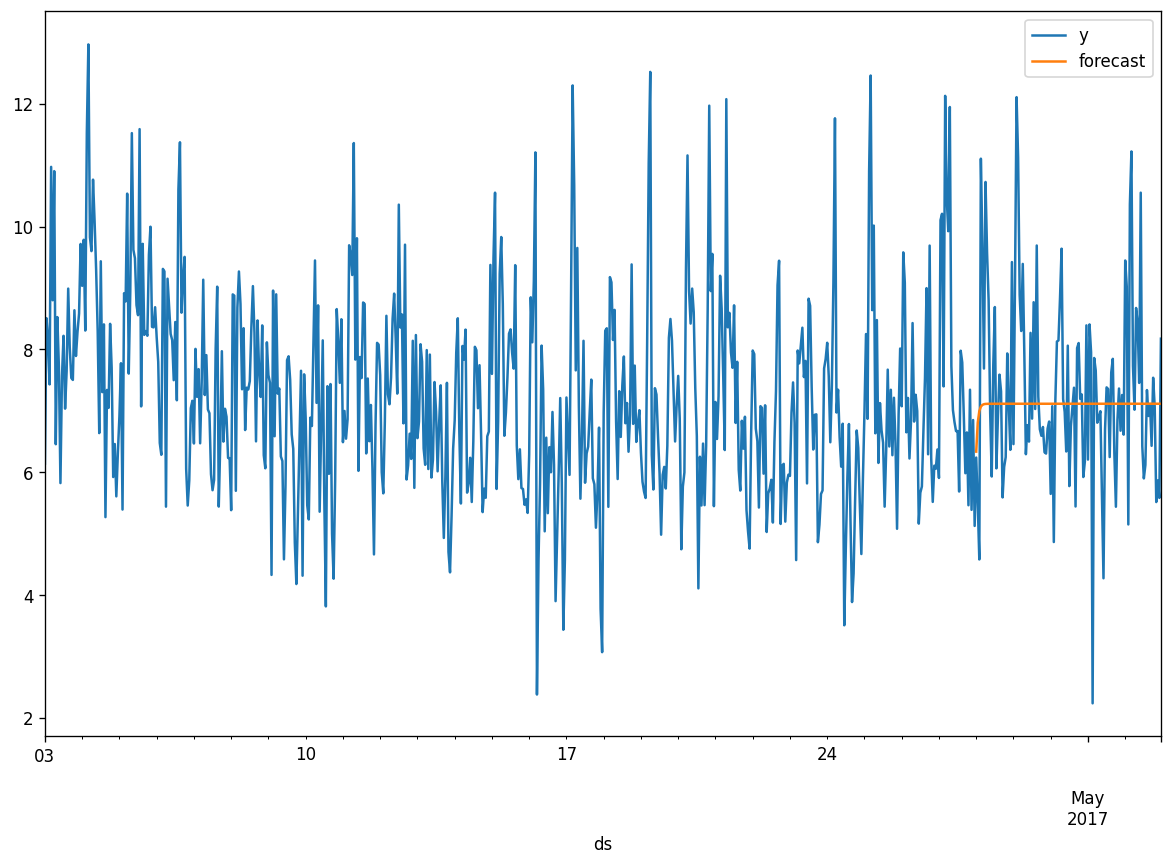

In [ ]:
model=ARIMA(bts_data['y'],order=(1,1,1))
model_fit=model.fit()
bts_data['forecast'] = model_fit.predict(start=600,end=720,dynamic=True)
bts_data[['y', 'forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='ds'>

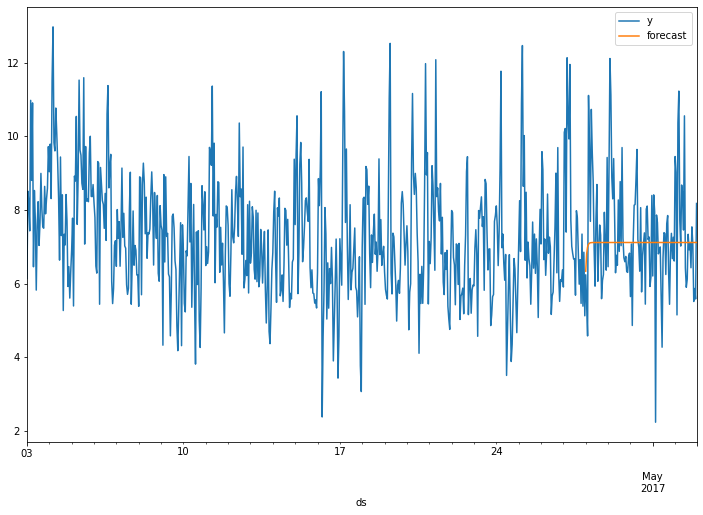

In [17]:
fig, ax = plt.subplots()
bts_data[['y', 'forecast']].plot(figsize=(12,8), ax=ax)

<AxesSubplot:xlabel='ds'>

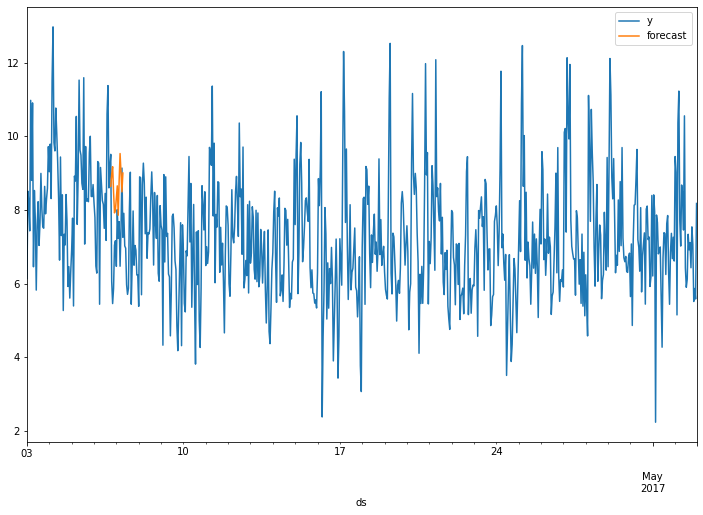

In [7]:
import statsmodels.api as sm
model=sm.tsa.statespace.SARIMAX(bts_data['y'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
bts_data['forecast']=results.predict(start=90,end=103,dynamic=True)
bts_data[['y','forecast']].plot(figsize=(12,8))

# Coba tune

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [31]:
def find_d(data):
    result = adfuller(data)
    p_value = result[1]
    count = 0
    while p_value > 0.05 and count<10:
        data = data.diff()
        result = adfuller(data)
        p_value = result[1]
        count+=1
    return count

def diff_data(data, n):
    for i in range(n):
        data = data.diff()
    return data.values

In [61]:
def plot_d(data, n):
    data = diff_data(data, n)
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(data)
    ax[0].set_title(f'{n} Order Differencing')
    plot_acf(data, ax=ax[1])
    return fig

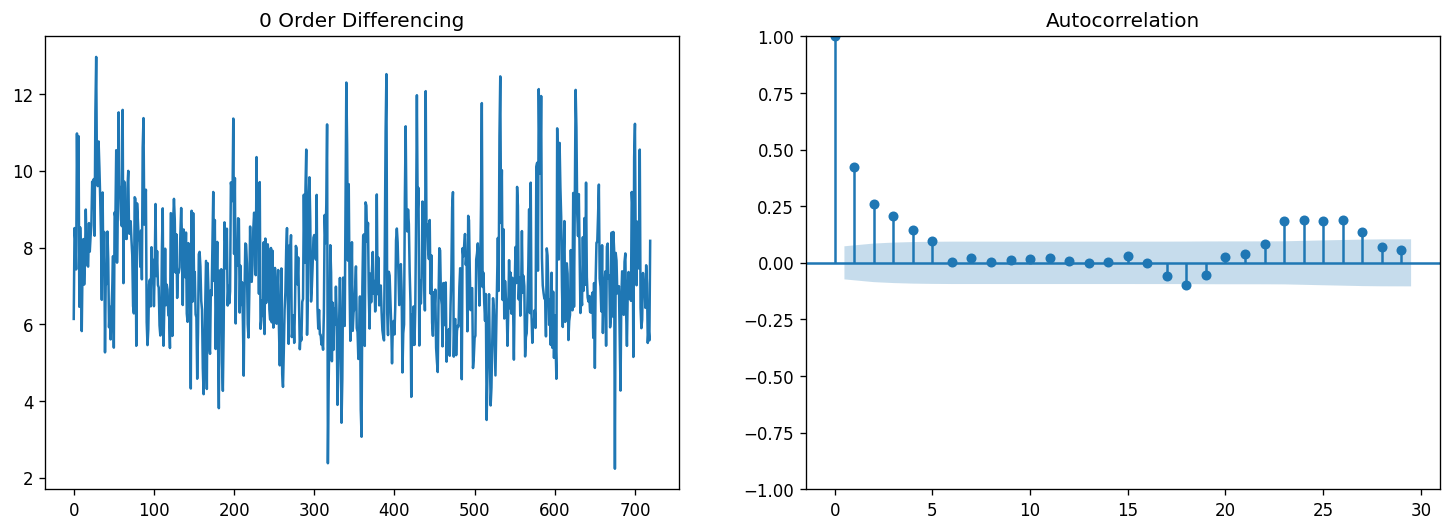

In [72]:
fig = plot_d(bts_data['y'], 0)

In [67]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

In [70]:
def plot_p(data, n):
    data = diff_data(data, n)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(data)
    axes[0].set_title(f'{n} Order Differencing')
    axes[1].set(ylim=(0,5))
    plot_pacf(data, ax=axes[1])
    return fig

C:\Users\danen\anaconda3\envs\streamlit\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


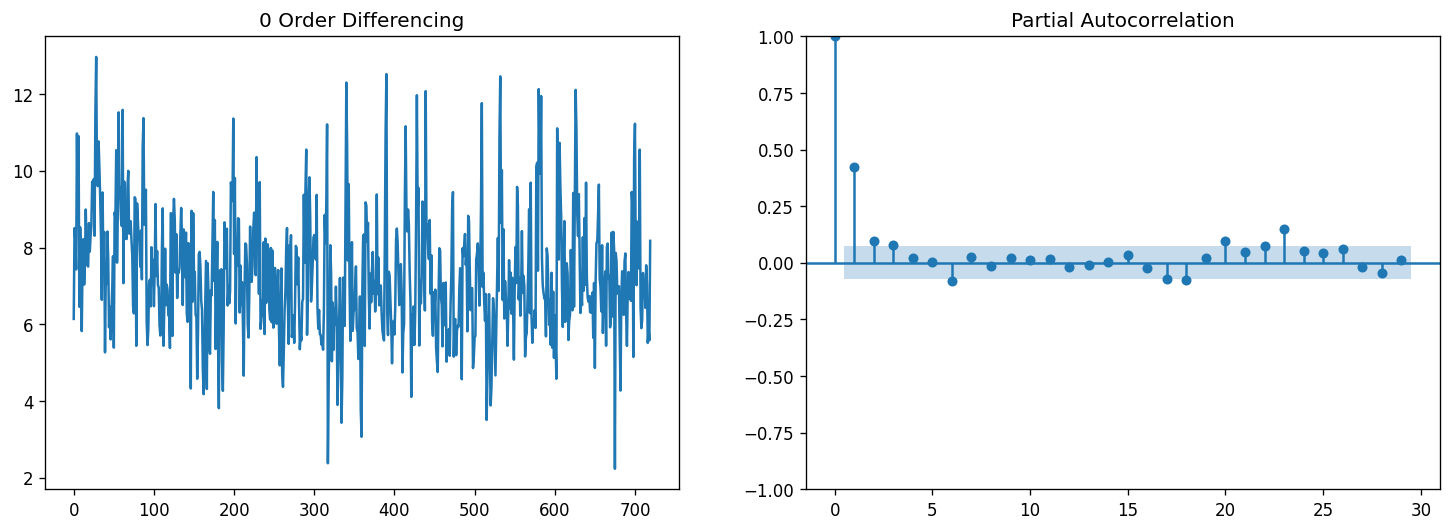

In [71]:
fig = plot_p(bts_data['y'], 0)

In [65]:
def plot_q(data, n):
    data = diff_data(data, n)
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].plot(data)
    axes[0].set_title(f'{n} Order Differencing')
    axes[1].set(ylim=(0,1.2))
    plot_acf(data, ax=axes[1])
    return fig

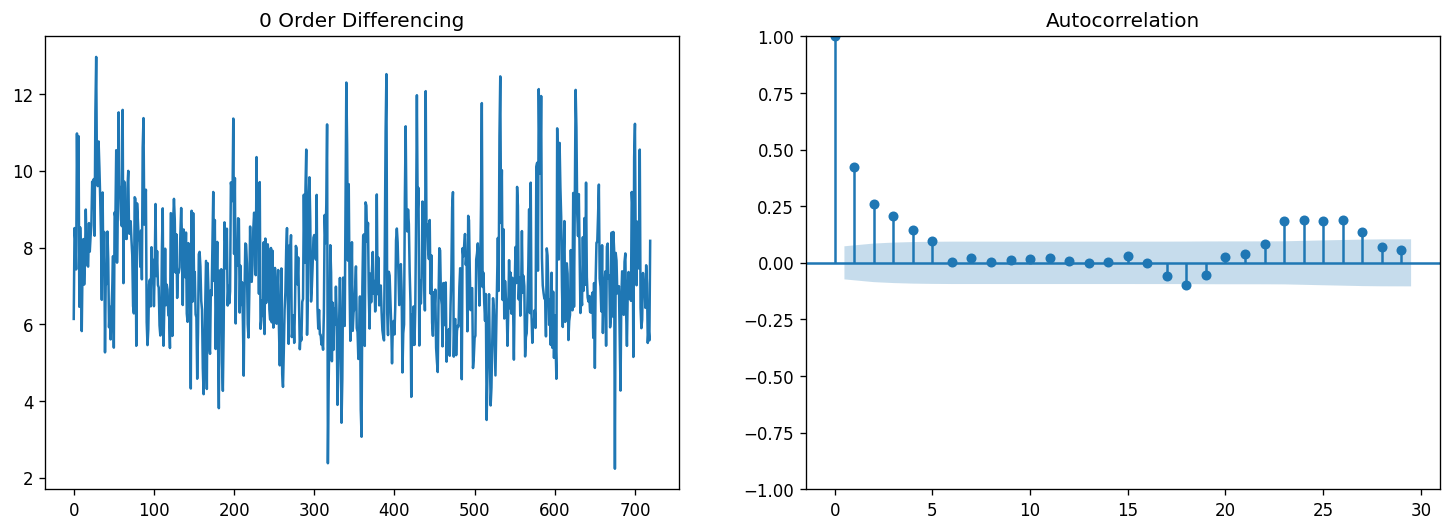

In [73]:
fig = plot_q(bts_data['y'], 0)